<a href="https://colab.research.google.com/github/maguid28/CS6271-EvolutionaryComputation/blob/main/GP_Lecture_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min       	nevals	std    	avg 	gen	max	min	nevals	std    
0  	20    	1.98978	0  	27.2045	0.00209246	20    	5.81297	3.45	0  	7  	2  	20    	1.49917
1  	6     	0.182169	1  	1.01151	0.00209246	6     	0.308179	4.4 	1  	9  	2  	6     	2.10713
2  	10    	0.0700778	2  	0.86508	0.00209246	10    	0.186242	5.8 	2  	9  	2  	10    	2.1587 
3  	10    	0.0918531	3  	1.21053	0.00209246	10    	0.271504	7   	3  	9  	5  	10    	0.894427
4  	14    	0.0903638	4  	0.389949	0.00209246	14    	0.151775	7   	4  	9  	5  	14    	1.26491 
5  	16    	0.137141 	5  	1.01151 	0.00209246	16    	0.229209	7   	5  	9  	5  	16    	0.894427
6  	12    	0.108563 	6  	0.389949	0.00209246	12    	0.12704 	7   	6  	9  	5  	12    	1.09545 
7  	6     	0.0198522	7  	0.0998331

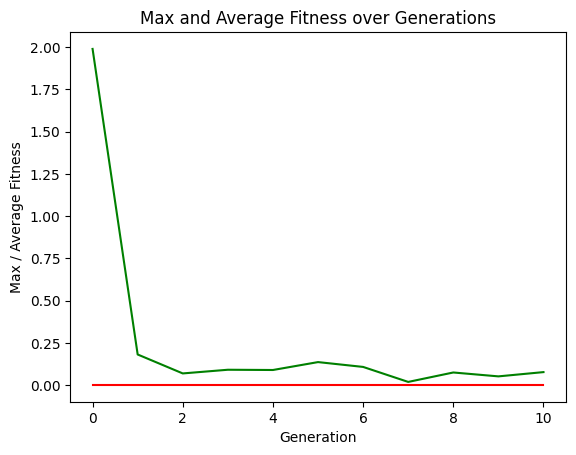

In [3]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

# Genetic Programming constants:
POPULATION_SIZE = 20
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 10

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)


# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

#this is a minimisation problem. we want to minimise the error for that function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**6 - x**5 - x**4 - x**3 - x**2 - x)**2 for x in points)
    #sqerrors = ((func(x) - x - 23)**2 for x in points)
    myError = math.fsum(sqerrors) / len(points)
    if myError>1000:
       myError=1000
    return myError,

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-5,5)])
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

def main():


    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                   ngen=MAX_GENERATIONS, stats=mstats,
                                   halloffame=hof, verbose=True)

    maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


    #Genetic Programming is done with this run - plot statistics:
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()

if __name__ == "__main__":
    main()